In [84]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

# Device

In [135]:
device = torch.device('cuda')
# device = torch.device('cpu')

# Dataset

In [148]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))
        self.y = torch.Tensor(D[:, -1:])
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [149]:
Img = Images()
Img.to(device)

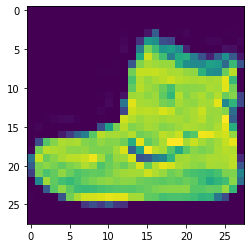

In [150]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [151]:
sampler = torch.utils.data.RandomSampler(Img)

In [159]:
dataLoader = torch.utils.data.DataLoader(Img, sampler=sampler, batch_size=500)

# Autoencoder

In [153]:
class AUTOENC(nn.Module):
    def __init__(self):
        super(AUTOENC, self).__init__()
        
        a = 50
        b = 100
        c = 150
        
        self.conv1 = nn.Conv2d(1, a, 5)
        self.conv2 = nn.Conv2d(a, b, 5)
        self.conv3 = nn.Conv2d(b, c, 5)
        self.conv4 = nn.Conv2d(c, b, 5)
        self.conv5 = nn.Conv2d(b, a, 5)
        self.conv6 = nn.Conv2d(a, 1, 5)
        
    def forward(self, X):
        X = self.conv1(F.pad(X,(2,2,2,2)))
        X = self.conv2(F.pad(X,(2,2,2,2)))
        X = self.conv3(F.pad(X,(2,2,2,2)))
        X = self.conv4(F.pad(X,(2,2,2,2)))
        X = self.conv5(F.pad(X,(2,2,2,2)))
        X = self.conv6(F.pad(X,(2,2,2,2)))
        return X

# Training

In [154]:
model = AUTOENC().to(device)

In [155]:
opt = optim.Adam(model.parameters(), lr=0.001)

In [162]:
EPOCHS=100
for epoch in range(EPOCHS):
    i = 1
    for X, y in tqdm_notebook(dataLoader):
        model.zero_grad()
        X_pred = model.forward(X)
        L = torch.sum((X - X_pred)**2)
        L.backward()
        opt.step()

        # Print
        if (i % (len(dataLoader)//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L))
        i += 1

Iteration 14 
        L: 16983874.0000
Iteration 28 
        L: 17580170.0000
Iteration 42 
        L: 17060336.0000
Iteration 56 
        L: 17101158.0000
Iteration 70 
        L: 16434372.0000
Iteration 84 
        L: 16194686.0000
Iteration 98 
        L: 17376748.0000
Iteration 112 
        L: 16175040.0000
Iteration 126 
        L: 16787246.0000
Iteration 140 
        L: 16737868.0000


Iteration 14 
        L: 17118650.0000
Iteration 28 
        L: 16901354.0000
Iteration 42 
        L: 15820727.0000
Iteration 56 
        L: 16053395.0000
Iteration 70 
        L: 16865020.0000
Iteration 84 
        L: 15888139.0000
Iteration 98 
        L: 16091542.0000
Iteration 112 
        L: 15871144.0000
Iteration 126 
        L: 16344349.0000
Iteration 140 
        L: 16544577.0000


Iteration 14 
        L: 15177517.0000
Iteration 28 
        L: 15594786.0000
Iteration 42 
        L: 16089191.0000
Iteration 56 
        L: 15471973.0000
Iteration 70 
        L: 15498055.0000
Iteration 84 
        L: 14734862.0000
Iteration 98 
        L: 15581860.0000
Iteration 112 
        L: 15245041.0000
Iteration 126 
        L: 14752916.0000
Iteration 140 
        L: 15110198.0000


Iteration 14 
        L: 14742619.0000
Iteration 28 
        L: 15268560.0000
Iteration 42 
        L: 14804883.0000
Iteration 56 
        L: 14475916.0000
Iteration 70 
        L: 14541431.0000
Iteration 84 
        L: 14606321.0000
Iteration 98 
        L: 14493756.0000
Iteration 112 
        L: 14829248.0000
Iteration 126 
        L: 14008611.0000
Iteration 140 
        L: 14202750.0000


Iteration 14 
        L: 14419715.0000
Iteration 28 
        L: 14233765.0000
Iteration 42 
        L: 13872940.0000
Iteration 56 
        L: 13329316.0000
Iteration 70 
        L: 14148402.0000
Iteration 84 
        L: 13460923.0000
Iteration 98 
        L: 13263546.0000
Iteration 112 
        L: 13929807.0000
Iteration 126 
        L: 13529267.0000
Iteration 140 
        L: 13382727.0000


Iteration 14 
        L: 13652826.0000
Iteration 28 
        L: 13291578.0000
Iteration 42 
        L: 13336498.0000
Iteration 56 
        L: 12684129.0000
Iteration 70 
        L: 13770138.0000
Iteration 84 
        L: 12474074.0000
Iteration 98 
        L: 12644795.0000
Iteration 112 
        L: 13040064.0000
Iteration 126 
        L: 12937196.0000
Iteration 140 
        L: 12614979.0000


Iteration 14 
        L: 12901476.0000
Iteration 28 
        L: 12371876.0000
Iteration 42 
        L: 13250806.0000
Iteration 56 
        L: 12610151.0000
Iteration 70 
        L: 12294532.0000
Iteration 84 
        L: 12596618.0000
Iteration 98 
        L: 12468188.0000
Iteration 112 
        L: 12498303.0000
Iteration 126 
        L: 11748946.0000
Iteration 140 
        L: 13000181.0000


Iteration 14 
        L: 12529201.0000
Iteration 28 
        L: 12300197.0000
Iteration 42 
        L: 11799853.0000
Iteration 56 
        L: 12110212.0000
Iteration 70 
        L: 12612548.0000
Iteration 84 
        L: 11835157.0000
Iteration 98 
        L: 11766552.0000
Iteration 112 
        L: 11606964.0000
Iteration 126 
        L: 12464079.0000
Iteration 140 
        L: 11730022.0000


Iteration 14 
        L: 11851400.0000
Iteration 28 
        L: 11944682.0000
Iteration 42 
        L: 10661096.0000
Iteration 56 
        L: 11781009.0000
Iteration 70 
        L: 10821526.0000
Iteration 84 
        L: 11043106.0000
Iteration 98 
        L: 10543228.0000
Iteration 112 
        L: 11190042.0000
Iteration 126 
        L: 11640369.0000
Iteration 140 
        L: 11251836.0000


Iteration 14 
        L: 11558963.0000
Iteration 28 
        L: 10939485.0000
Iteration 42 
        L: 10918586.0000
Iteration 56 
        L: 11592221.0000
Iteration 70 
        L: 10806870.0000
Iteration 84 
        L: 11192400.0000
Iteration 98 
        L: 10551102.0000
Iteration 112 
        L: 10465114.0000
Iteration 126 
        L: 10643528.0000
Iteration 140 
        L: 11277239.0000


Iteration 14 
        L: 11060507.0000
Iteration 28 
        L: 10889174.0000
Iteration 42 
        L: 10457065.0000
Iteration 56 
        L: 10906536.0000
Iteration 70 
        L: 10503804.0000
Iteration 84 
        L: 10562622.0000
Iteration 98 
        L: 10778959.0000
Iteration 112 
        L: 10668288.0000
Iteration 126 
        L: 10370740.0000
Iteration 140 
        L: 9792398.0000


Iteration 14 
        L: 9822178.0000
Iteration 28 
        L: 9544834.0000
Iteration 42 
        L: 9716272.0000
Iteration 56 
        L: 10644092.0000
Iteration 70 
        L: 10023734.0000
Iteration 84 
        L: 10329432.0000
Iteration 98 
        L: 10242211.0000
Iteration 112 
        L: 9390226.0000
Iteration 126 
        L: 9870187.0000
Iteration 140 
        L: 9726389.0000


Iteration 14 
        L: 9613513.0000
Iteration 28 
        L: 9183283.0000
Iteration 42 
        L: 9400774.0000
Iteration 56 
        L: 9413181.0000
Iteration 70 
        L: 10179359.0000
Iteration 84 
        L: 9964331.0000
Iteration 98 
        L: 9255942.0000
Iteration 112 
        L: 9339510.0000
Iteration 126 
        L: 9247928.0000
Iteration 140 
        L: 9575358.0000


Iteration 14 
        L: 10459368.0000
Iteration 28 
        L: 9112069.0000
Iteration 42 
        L: 9484782.0000
Iteration 56 
        L: 9538425.0000
Iteration 70 
        L: 9014051.0000
Iteration 84 
        L: 8869418.0000
Iteration 98 
        L: 87040240.0000
Iteration 112 
        L: 14581301.0000
Iteration 126 
        L: 13608562.0000
Iteration 140 
        L: 9269725.0000


Iteration 14 
        L: 9047004.0000
Iteration 28 
        L: 9082132.0000
Iteration 42 
        L: 9126497.0000
Iteration 56 
        L: 8646360.0000
Iteration 70 
        L: 9016615.0000
Iteration 84 
        L: 8841286.0000
Iteration 98 
        L: 8409677.0000
Iteration 112 
        L: 8663664.0000
Iteration 126 
        L: 8511225.0000
Iteration 140 
        L: 8650115.0000


Iteration 14 
        L: 8221018.0000
Iteration 28 
        L: 8339546.5000
Iteration 42 
        L: 8234949.5000
Iteration 56 
        L: 7925943.0000
Iteration 70 
        L: 8015815.5000
Iteration 84 
        L: 8009719.0000
Iteration 98 
        L: 8229097.0000
Iteration 112 
        L: 8163731.5000
Iteration 126 
        L: 7818361.0000
Iteration 140 
        L: 8143364.5000


Iteration 14 
        L: 7396184.0000
Iteration 28 
        L: 8052648.0000
Iteration 42 
        L: 7613255.0000
Iteration 56 
        L: 7813151.5000
Iteration 70 
        L: 8013957.0000
Iteration 84 
        L: 7921332.0000
Iteration 98 
        L: 7942709.5000
Iteration 112 
        L: 7386647.0000
Iteration 126 
        L: 7433232.5000
Iteration 140 
        L: 7628102.0000


Iteration 14 
        L: 7836087.0000
Iteration 28 
        L: 7580832.0000
Iteration 42 
        L: 7615570.0000
Iteration 56 
        L: 7126027.0000
Iteration 70 
        L: 7339238.0000
Iteration 84 
        L: 7804316.0000
Iteration 98 
        L: 7428593.0000
Iteration 112 
        L: 7635955.5000
Iteration 126 
        L: 7533521.5000
Iteration 140 
        L: 7184308.5000


Iteration 14 
        L: 8221932.0000
Iteration 28 
        L: 136256960.0000
Iteration 42 
        L: 20117290.0000
Iteration 56 
        L: 7457615.0000
Iteration 70 
        L: 8023838.5000
Iteration 84 
        L: 6651585.5000
Iteration 98 
        L: 6777945.0000
Iteration 112 
        L: 6569100.0000
Iteration 126 
        L: 6994146.5000
Iteration 140 
        L: 6725737.0000


Iteration 14 
        L: 6667033.5000
Iteration 28 
        L: 6924468.5000
Iteration 42 
        L: 6887796.5000
Iteration 56 
        L: 6510672.5000
Iteration 70 
        L: 6285710.0000
Iteration 84 
        L: 6392288.0000
Iteration 98 
        L: 6564946.5000
Iteration 112 
        L: 6775800.5000
Iteration 126 
        L: 6496318.0000
Iteration 140 
        L: 6299590.5000


Iteration 14 
        L: 6414586.0000
Iteration 28 
        L: 6700227.0000
Iteration 42 
        L: 6458048.5000
Iteration 56 
        L: 6538981.0000
Iteration 70 
        L: 5889569.0000
Iteration 84 
        L: 5998096.0000
Iteration 98 
        L: 6311407.5000
Iteration 112 
        L: 6083295.0000
Iteration 126 
        L: 14707835.0000
Iteration 140 
        L: 12108416.0000


Iteration 14 
        L: 6758485.0000
Iteration 28 
        L: 5878282.5000
Iteration 42 
        L: 5647047.0000
Iteration 56 
        L: 6125314.5000
Iteration 70 
        L: 5860782.0000
Iteration 84 
        L: 5979093.5000
Iteration 98 
        L: 5923281.5000
Iteration 112 
        L: 5825490.5000
Iteration 126 
        L: 5910140.0000
Iteration 140 
        L: 6198375.0000


Iteration 14 
        L: 16881454.0000
Iteration 28 
        L: 12274095.0000
Iteration 42 
        L: 10160204.0000
Iteration 56 
        L: 8141550.5000
Iteration 70 
        L: 6034170.5000
Iteration 84 
        L: 5816135.0000
Iteration 98 
        L: 5229341.5000
Iteration 112 
        L: 5335832.0000
Iteration 126 
        L: 5359190.5000
Iteration 140 
        L: 5363132.5000


Iteration 14 
        L: 5600116.0000
Iteration 28 
        L: 5386486.5000
Iteration 42 
        L: 5279403.0000
Iteration 56 
        L: 5455155.0000
Iteration 70 
        L: 5314996.0000
Iteration 84 
        L: 4802362.0000
Iteration 98 
        L: 5043347.0000
Iteration 112 
        L: 4661105.5000
Iteration 126 
        L: 8146641.0000
Iteration 140 
        L: 6036066.0000


Iteration 14 
        L: 5225585.0000
Iteration 28 
        L: 5327606.5000
Iteration 42 
        L: 5469567.5000
Iteration 56 
        L: 10741026.0000
Iteration 70 
        L: 6555596.5000
Iteration 84 
        L: 4765893.0000
Iteration 98 
        L: 4741731.0000
Iteration 112 
        L: 4964993.5000
Iteration 126 
        L: 6607839.0000
Iteration 140 
        L: 8843716.0000


Iteration 14 
        L: 4926353.0000
Iteration 28 
        L: 4707381.0000
Iteration 42 
        L: 4483325.0000
Iteration 56 
        L: 11804824.0000
Iteration 70 
        L: 4928440.0000
Iteration 84 
        L: 12457640.0000
Iteration 98 
        L: 12829624.0000
Iteration 112 
        L: 10126448.0000
Iteration 126 
        L: 4986128.0000
Iteration 140 
        L: 6476339.5000


Iteration 14 
        L: 4837471.0000
Iteration 28 
        L: 4326251.5000
Iteration 42 
        L: 4718311.0000
Iteration 56 
        L: 4400147.0000
Iteration 70 
        L: 4923349.5000
Iteration 84 
        L: 5151263.0000
Iteration 98 
        L: 18962040.0000
Iteration 112 
        L: 4937683.0000
Iteration 126 
        L: 4329583.5000
Iteration 140 
        L: 7857445.0000


Iteration 14 
        L: 4666604.5000
Iteration 28 
        L: 3988831.0000
Iteration 42 
        L: 4826482.5000
Iteration 56 
        L: 5682470.0000
Iteration 70 
        L: 11428717.0000
Iteration 84 
        L: 4774575.5000
Iteration 98 
        L: 3889871.0000
Iteration 112 
        L: 4225175.0000
Iteration 126 
        L: 3901300.5000
Iteration 140 
        L: 3687485.7500


Iteration 14 
        L: 3633598.7500
Iteration 28 
        L: 3817341.2500
Iteration 42 
        L: 8408304.0000
Iteration 56 
        L: 27916096.0000
Iteration 70 
        L: 3970889.2500
Iteration 84 
        L: 3961746.7500
Iteration 98 
        L: 4126437.2500
Iteration 112 
        L: 3648786.0000
Iteration 126 
        L: 3745191.5000
Iteration 140 
        L: 3724140.5000


Iteration 14 
        L: 3530515.5000
Iteration 28 
        L: 3520708.5000
Iteration 42 
        L: 3592735.5000
Iteration 56 
        L: 3485038.5000
Iteration 70 
        L: 3207312.5000
Iteration 84 
        L: 3525046.0000
Iteration 98 
        L: 3466145.5000
Iteration 112 
        L: 3289997.0000
Iteration 126 
        L: 3403878.5000
Iteration 140 
        L: 4431062.0000


Iteration 14 
        L: 8606880.0000
Iteration 28 
        L: 3513708.0000
Iteration 42 
        L: 3480543.5000
Iteration 56 
        L: 3860565.5000
Iteration 70 
        L: 4842217.0000
Iteration 84 
        L: 3163661.0000
Iteration 98 
        L: 3537413.0000
Iteration 112 
        L: 2959595.0000
Iteration 126 
        L: 5925681.0000
Iteration 140 
        L: 5903649.5000


Iteration 14 
        L: 3530689.5000
Iteration 28 
        L: 10768435.0000
Iteration 42 
        L: 4110951.0000
Iteration 56 
        L: 2843659.5000
Iteration 70 
        L: 3121526.0000
Iteration 84 
        L: 3838943.5000
Iteration 98 
        L: 3324399.2500
Iteration 112 
        L: 5613457.0000
Iteration 126 
        L: 24279768.0000
Iteration 140 
        L: 3248091.5000


Iteration 14 
        L: 3235050.7500
Iteration 28 
        L: 2833583.5000
Iteration 42 
        L: 2790495.0000
Iteration 56 
        L: 2655282.0000
Iteration 70 
        L: 2988930.2500
Iteration 84 
        L: 2754935.0000
Iteration 98 
        L: 2446514.0000
Iteration 112 
        L: 3442693.7500
Iteration 126 
        L: 4478289.5000
Iteration 140 
        L: 2926468.0000


Iteration 14 
        L: 3117901.2500
Iteration 28 
        L: 63642448.0000
Iteration 42 
        L: 14205888.0000
Iteration 56 
        L: 3812297.0000
Iteration 70 
        L: 3424056.7500
Iteration 84 
        L: 2744724.2500
Iteration 98 
        L: 2458797.0000
Iteration 112 
        L: 2416291.0000
Iteration 126 
        L: 2606092.5000
Iteration 140 
        L: 2414369.7500


Iteration 14 
        L: 4342808.5000
Iteration 28 
        L: 12285254.0000
Iteration 42 
        L: 8781424.0000
Iteration 56 
        L: 3803024.7500
Iteration 70 
        L: 2456628.7500
Iteration 84 
        L: 2447593.0000
Iteration 98 
        L: 2270373.7500
Iteration 112 
        L: 2348844.2500
Iteration 126 
        L: 2261547.5000
Iteration 140 
        L: 2174836.5000


Iteration 14 
        L: 3488699.2500
Iteration 28 
        L: 2515361.5000
Iteration 42 
        L: 3794573.7500
Iteration 56 
        L: 3807564.7500
Iteration 70 
        L: 2348041.0000
Iteration 84 
        L: 2755506.0000
Iteration 98 
        L: 2248530.5000
Iteration 112 
        L: 2224996.7500
Iteration 126 
        L: 2005169.5000
Iteration 140 
        L: 1906715.7500


Iteration 14 
        L: 3402102.2500
Iteration 28 
        L: 53068004.0000
Iteration 42 
        L: 3168848.0000
Iteration 56 
        L: 2777577.0000
Iteration 70 
        L: 2883366.0000
Iteration 84 
        L: 1890031.8750
Iteration 98 
        L: 3300579.7500
Iteration 112 
        L: 2045599.7500
Iteration 126 
        L: 1848896.2500
Iteration 140 
        L: 1915838.2500


Iteration 14 
        L: 13774711.0000
Iteration 28 
        L: 3131312.7500
Iteration 42 
        L: 10801556.0000
Iteration 56 
        L: 3072371.7500
Iteration 70 
        L: 2218559.2500
Iteration 84 
        L: 1849337.3750
Iteration 98 
        L: 1746961.8750
Iteration 112 
        L: 1656754.1250
Iteration 126 
        L: 1737860.2500
Iteration 140 
        L: 1625904.6250


Iteration 14 
        L: 2007466.8750
Iteration 28 
        L: 7434512.0000
Iteration 42 
        L: 7165305.0000
Iteration 56 
        L: 4909912.0000
Iteration 70 
        L: 4384309.5000
Iteration 84 
        L: 1773421.5000
Iteration 98 
        L: 1605866.1250
Iteration 112 
        L: 1800819.8750
Iteration 126 
        L: 2339789.0000
Iteration 140 
        L: 51434052.0000


Iteration 14 
        L: 12339954.0000
Iteration 28 
        L: 3462377.7500
Iteration 42 
        L: 1557981.2500
Iteration 56 
        L: 2739095.7500
Iteration 70 
        L: 1616307.7500
Iteration 84 
        L: 1499226.2500
Iteration 98 
        L: 1457960.5000
Iteration 112 
        L: 1559398.1250
Iteration 126 
        L: 8227097.0000
Iteration 140 
        L: 13618417.0000


Iteration 14 
        L: 2667974.5000
Iteration 28 
        L: 5550618.0000
Iteration 42 
        L: 2280118.0000
Iteration 56 
        L: 6621515.0000
Iteration 70 
        L: 1914388.7500
Iteration 84 
        L: 5651262.0000
Iteration 98 
        L: 9369668.0000
Iteration 112 
        L: 3421257.5000
Iteration 126 
        L: 1592444.2500
Iteration 140 
        L: 1291267.5000


Iteration 14 
        L: 6066104.0000
Iteration 28 
        L: 1243024.1250
Iteration 42 
        L: 1573981.5000
Iteration 56 
        L: 5664875.5000
Iteration 70 
        L: 2194786.5000
Iteration 84 
        L: 2094116.2500
Iteration 98 
        L: 19797940.0000
Iteration 112 
        L: 38788872.0000
Iteration 126 
        L: 2734133.0000
Iteration 140 
        L: 11477634.0000


Iteration 14 
        L: 9469802.0000
Iteration 28 
        L: 4832645.5000
Iteration 42 
        L: 2162794.2500
Iteration 56 
        L: 1052022.2500
Iteration 70 
        L: 1179943.5000
Iteration 84 
        L: 1248390.5000
Iteration 98 
        L: 3692475.2500
Iteration 112 
        L: 8115067.0000
Iteration 126 
        L: 14570852.0000
Iteration 140 
        L: 4948509.0000


Iteration 14 
        L: 4429151.0000
Iteration 28 
        L: 3595388.0000
Iteration 42 
        L: 5838907.0000
Iteration 56 
        L: 1479053.2500
Iteration 70 
        L: 950811.3750
Iteration 84 
        L: 29300288.0000
Iteration 98 
        L: 24593888.0000
Iteration 112 
        L: 8021129.0000
Iteration 126 
        L: 2550461.2500
Iteration 140 
        L: 1056004.7500


Iteration 14 
        L: 1051258.7500
Iteration 28 
        L: 931126.7500
Iteration 42 
        L: 989121.7500
Iteration 56 
        L: 964169.2500
Iteration 70 
        L: 896498.0000
Iteration 84 
        L: 27375032.0000
Iteration 98 
        L: 8866239.0000
Iteration 112 
        L: 871357.6875
Iteration 126 
        L: 968422.6250
Iteration 140 
        L: 2736754.0000


Iteration 14 
        L: 1518062.5000
Iteration 28 
        L: 1471058.8750
Iteration 42 
        L: 5007472.0000
Iteration 56 
        L: 3300376.7500
Iteration 70 
        L: 1147797.0000
Iteration 84 
        L: 974410.5000
Iteration 98 
        L: 1741935.2500
Iteration 112 
        L: 3401781.0000
Iteration 126 
        L: 7929902.5000
Iteration 140 
        L: 6527727.5000


Iteration 14 
        L: 3127036.7500
Iteration 28 
        L: 52444188.0000
Iteration 42 
        L: 1143117.5000
Iteration 56 
        L: 812789.8750
Iteration 70 
        L: 2090720.1250
Iteration 84 
        L: 1823725.3750
Iteration 98 
        L: 14343358.0000
Iteration 112 
        L: 884445.0000
Iteration 126 
        L: 1089043.8750
Iteration 140 
        L: 3300340.2500


Iteration 14 
        L: 698444.5000
Iteration 28 
        L: 852563.6875
Iteration 42 
        L: 845652.6875
Iteration 56 
        L: 5467170.0000
Iteration 70 
        L: 15111316.0000
Iteration 84 
        L: 2478233.0000
Iteration 98 
        L: 9042612.0000
Iteration 112 
        L: 841910.4375
Iteration 126 
        L: 616814.5625
Iteration 140 
        L: 640480.8750


Iteration 14 
        L: 1876465.7500
Iteration 28 
        L: 28417084.0000
Iteration 42 
        L: 1738006.0000
Iteration 56 
        L: 6089466.0000
Iteration 70 
        L: 4742884.5000
Iteration 84 
        L: 1577381.3750
Iteration 98 
        L: 5671802.0000
Iteration 112 
        L: 1212936.1250
Iteration 126 
        L: 1055023.0000
Iteration 140 
        L: 1854228.1250


Iteration 14 
        L: 3721804.5000
Iteration 28 
        L: 585102.5000
Iteration 42 
        L: 900321.0000
Iteration 56 
        L: 804833.6250
Iteration 70 
        L: 1762776.2500
Iteration 84 
        L: 4521575.5000


KeyboardInterrupt: 